In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [3]:
# import
rj = gpd.read_file('/content/RJ_Municipios_2022.shp')

<Axes: >

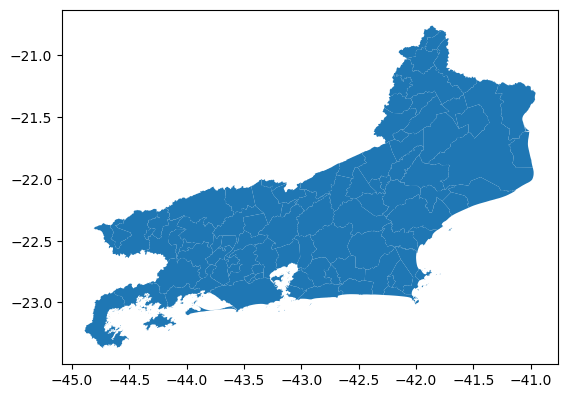

In [12]:
# filtering
rj.plot()

## Zonal Statistics w/ raster files

In [15]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

In [16]:
# downscale
# REMEMBER RAFAEL's POINT - Due to the rescaling method, we have measurement error in the interpolation.
# How would you fix this exercise, class?
 
from rasterio.enums import Resampling

output_file = '/content/flii_SouthAmerica_dr.tif'
input_file = '/content/flii_SouthAmerica.tif'

with rasterio.open(input_file) as src:
    # read metadata
    metadata = src.meta

    # specify new dimensions
    scale_factor = 0.1 # downscale by a factor of 10
    new_height = int(src.height * scale_factor)
    new_width = int(src.width * scale_factor)
    new_transform = src.transform * src.transform.scale(
        (src.width/new_width), (src.height/new_height)
    )
    metadata.update({
        'height':new_height,
        'width':new_width,
        'transform':new_transform,
        'nodata':-9999, # fixing nodata
        'dtype':'float32'
    })
    with rasterio.open(output_file, 'w', **metadata) as dst:
        # resampling data to target shape
        for i in range(1, src.count +1):
            dst.write(
                src.read(i,
                         out_shape=(src.count, new_height, new_width),
                         resampling = Resampling.bilinear
                ),
                indexes=i
            )

In [17]:
# read array
with rasterio.open(output_file) as src:
    print(src.crs)
    array = src.read(1)
    affine = src.transform

EPSG:4326


In [18]:
# remember, -9999 is np.nan!
array[array == -9999] = np.nan

In [22]:
from rasterio.mask import mask

rj = rj.to_crs('epsg:4326')
# lets crop RJ
with rasterio.open(output_file) as src:
    rj_array, rj_transform = mask(src, shapes=rj.geometry, crop=True, nodata=np.nan)

<Axes: >

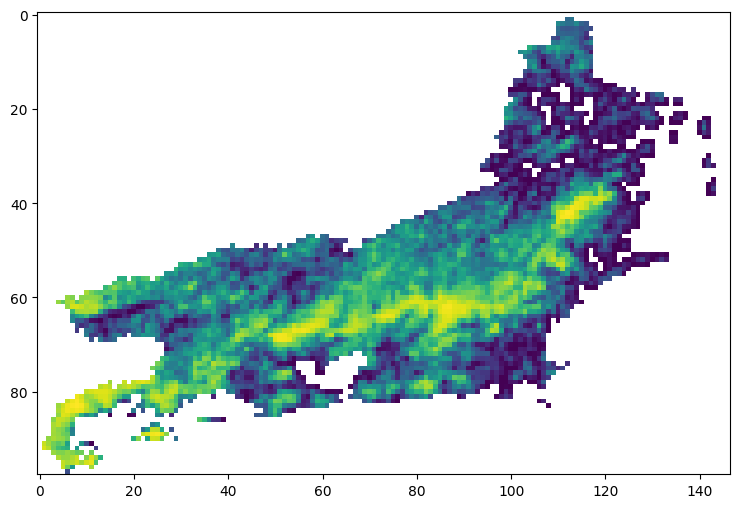

In [23]:
f,ax = plt.subplots(figsize=(10,6))
show(rj_array, ax=ax)

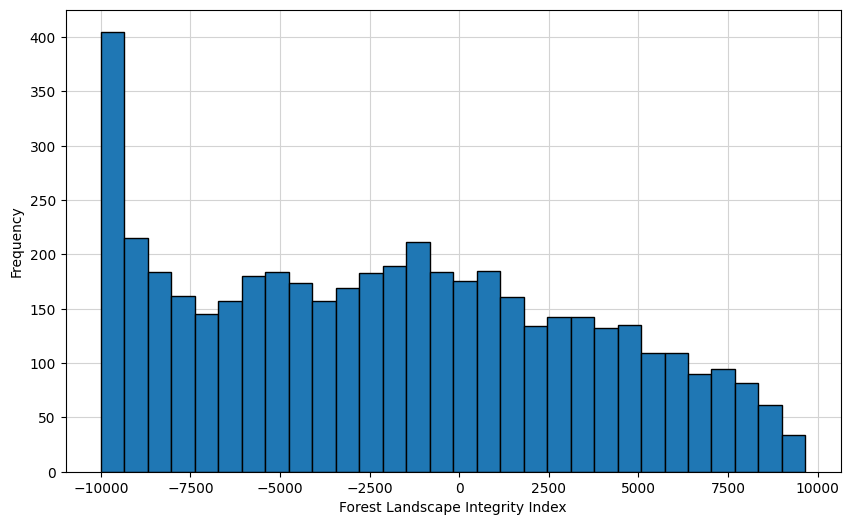

In [24]:
# lets check the data distribution!
f, ax = plt.subplots(figsize=(10,6))
ax.hist(rj_array[rj_array!= np.nan].reshape(-1,1), bins=30, edgecolor='k')
ax.set_xlabel('Forest Landscape Integrity Index')
ax.set_ylabel('Frequency')
ax.grid(color='lightgray')
ax.set_axisbelow(True)
plt.show()


In [27]:
from rasterstats import zonal_stats

rj_array[rj_array<0] = np.nan

zs1 = zonal_stats(rj, rj_array[0], affine=rj_transform, stats=['mean'], nodata=np.nan)
zs2 = zonal_stats(rj, rj_array[0], affine=rj_transform, stats=['mean'], nodata=np.nan, alltouched= True)
rj['mean_flii1'] = [x['mean'] for x in zs1]
rj['mean_flii2'] = [x['mean'] for x in zs2]

In [29]:
rj['mean_flii1'] = rj['mean_flii1']/1000
rj['mean_flii2'] = rj['mean_flii2']/1000

In [32]:
rj

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,mean_flii1,mean_flii2
0,3300100,Angra dos Reis,RJ,813.420,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633...",6.120305,6.120305
1,3300159,Aperibé,RJ,94.542,"POLYGON ((-42.11437 -21.61204, -42.11394 -21.6...",NaN,NaN
2,3300209,Araruama,RJ,638.276,"POLYGON ((-42.28399 -22.93928, -42.28444 -22.9...",NaN,NaN
3,3300225,Areal,RJ,110.724,"POLYGON ((-43.09004 -22.23844, -43.09135 -22.2...",1.177625,1.177625
4,3300233,Armação dos Búzios,RJ,70.977,"MULTIPOLYGON (((-41.91872 -22.77162, -41.91854...",NaN,NaN
...,...,...,...,...,...,...,...
87,3306008,Três Rios,RJ,322.843,"POLYGON ((-43.23685 -22.13806, -43.23831 -22.1...",1.735875,1.735875
88,3306107,Valença,RJ,1300.767,"POLYGON ((-43.72940 -22.09312, -43.72927 -22.0...",1.524553,1.524553
89,3306156,Varre-Sai,RJ,201.938,"POLYGON ((-41.89492 -20.97015, -41.89490 -20.9...",0.231000,0.231000
90,3306206,Vassouras,RJ,536.073,"POLYGON ((-43.66409 -22.45808, -43.67771 -22.4...",1.286789,1.286789


<Axes: >

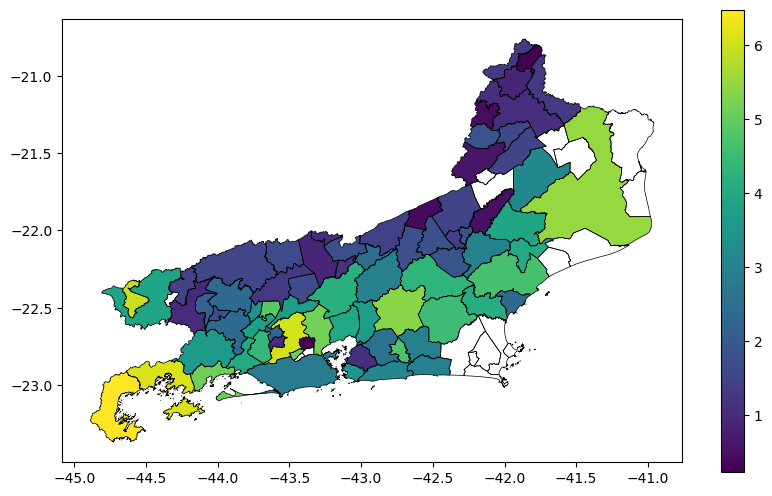

In [31]:
f, ax = plt.subplots(1,1 ,figsize=(10,6))
rj.plot(ax=ax, column='mean_flii2', cmap='viridis', legend=True)
rj.boundary.plot(ax=ax,lw=0.5,color='k')

## Zonal Statistics w/ another shapefile 

In [ ]:
# importing second data
rj = gpd.read_file('d:/Dropbox/Classes/env_lab/lectures/lecture_5/data/Limite_de_Bairros.shp')
ismfi = gpd.read_file('d:/Dropbox/Classes/env_lab/lectures/lecture_5/data/ismfi_grade/indice.shp')

<Axes: >

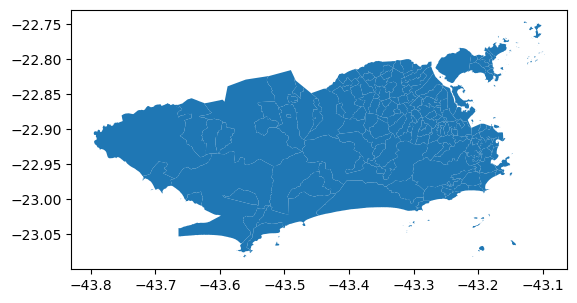

In [ ]:
rj.plot()

(619940.0160978794, 698942.9358587307, 7444399.431338712, 7485238.984202462)

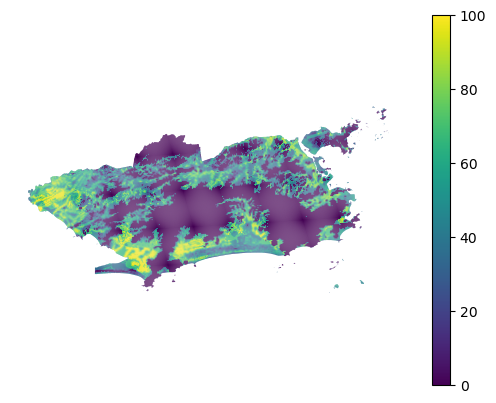

In [ ]:
ismfi.plot(column='ISMFI_corr', legend=True)
plt.axis('off')

In [ ]:
# FIXING CRS
rj = rj.to_crs(ismfi.crs)

In [ ]:
# Joining databases
merged = rj.sjoin(ismfi[['geometry','ISMFI_corr']],how='left',predicate='intersects')
merged

,objectid,área,nome,regiao_adm,area_plane,codbairro,codra,codbnum,link,rp,cod_rp,codbairro_,st_areasha,st_perimet,geometry,index_right,ISMFI_corr
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31653,24.600999
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31654,24.928217
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31655,28.467524
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31656,37.257764
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31657,34.314112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7775,0.000000
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7776,18.476684
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7777,21.985894
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7778,21.617264


In [ ]:
# merging dataframes
merged = merged[['codbairro','regiao_adm','ISMFI_corr']].groupby(['codbairro','regiao_adm']).agg('mean').reset_index().merge(rj[['codbairro','geometry']])

<Axes: >

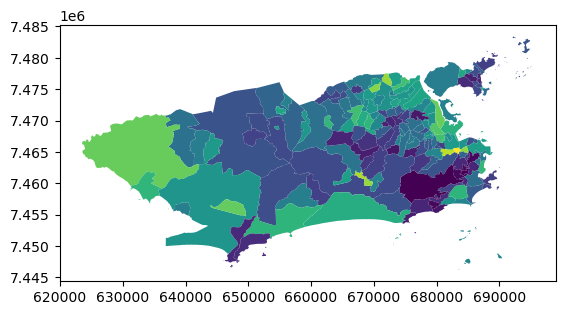

In [ ]:
# Plotting(?!)
merged.plot(column='ISMFI_corr')

In [ ]:
# turning it back to geodataframe
merged = gpd.GeoDataFrame(merged)

<Axes: >

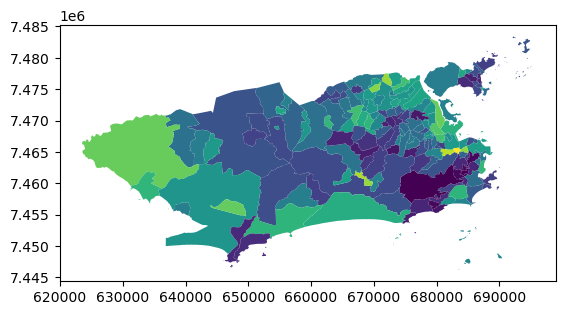

In [ ]:
#Plotting!
merged.plot(column='ISMFI_corr')

In [ ]:
# Dissolving
merged = merged[['regiao_adm','geometry','ISMFI_corr']].dissolve(by='regiao_adm',aggfunc='mean').reset_index()
merged

<Axes: >

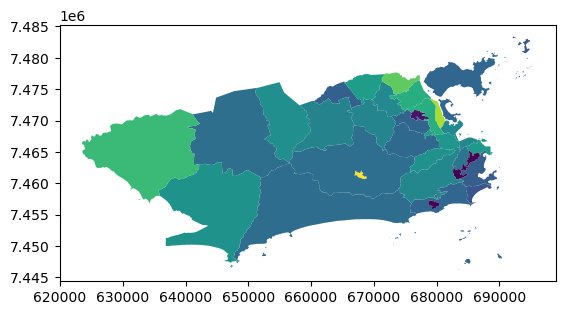

In [ ]:
#Plotting!
merged.plot(column='ISMFI_corr')